In [1]:
import torch
import sys
sys.path.append('../')
import time
from robust_tt import RTT 
from dyn_models.pushing_dyn_ttpi import pusher_slider_sys
torch.set_default_dtype(torch.float64)
%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
p_target = torch.tensor([0., 0., 0.]).view(1,-1).to(device)
dt=0.025

dyn_system =  pusher_slider_sys(p_target=p_target,dt=dt, device=device)
dyn_system_test =  pusher_slider_sys(p_target=p_target,dt=dt, device=device)

In [4]:
# dim=5
w = 0.5
state_max_c = torch.tensor([w,w,torch.pi, -0.065, 0.06]).to(device) # (s_x, s_y, s_theta, p_x, p_y) 
state_min_c =  torch.tensor([-w,-w,-torch.pi, -0.1, -0.06]).to(device)

state_max = torch.tensor([w,w,torch.pi, -0.065, 0.06, 3]).to(device) # (s_x, s_y, s_theta, p_x, p_y, face_id) 
state_min =  torch.tensor([-w,-w,-torch.pi, -0.1, -0.06, 0]).to(device)
is_state_c = torch.tensor([1]*len(state_max)).to(device)
is_state_c[-1] = 0

n = 100
n_state = [n]*5
n_state[2] = 100
n_action = 50

v = 0.1
action_max_c = torch.tensor([v, v]).to(device) # (p_ddx, p_ddy)
action_min_c = torch.tensor([0, -v]).to(device)
action_max =  torch.tensor([v,v,3]).to(device)
action_min = torch.tensor([0,-v,0]).to(device)

In [5]:
domain_state_c = []
for i in range(len(state_max_c)):#x,dx
    x_n = torch.linspace(state_min_c[i],0,int(n_state[i]/2)).to(device)
    x_p = torch.linspace(0,state_max_c[i],int(n_state[i]/2)).to(device)[1:]
    domain_state_c.append(torch.concat((x_n,x_p),dim=-1))
domain_state = domain_state_c  +[torch.tensor([0.,1.,2.,3.]).to(device)]
domain_action = [torch.tensor([0.,1.,2.,3.]).to(device)]+ [torch.linspace(action_min_c[i],action_max_c[i],n_action).to(device) for i in range(len(action_max_c))]

In [6]:
def forward_model(state,action):
    next_state = dyn_system.dynamics(state,action)
    return next_state


def reward(state,action):
    rewards = -1*dyn_system.cost_func(state,action,scale=w)
    return rewards

In [7]:
n_test = 100
dim_state = len(domain_state)
init_state = torch.empty((n_test,dim_state))
for i in range(dim_state):
    init_state[:,i] = state_min[i] + torch.rand(n_test).clip(0.25,0.75).to(device)*(state_max[i]-state_min[i])
state = init_state.to(device)


In [8]:
tol = torch.tensor([0.03, 0.03, 15/180*torch.pi]).to(device)[:3]

def callback(ttpi, state=state, file_name='fig',callback_count=0):
    print("Testing....")
    
    history = []
    T=2000
    traj = state[:,:].clone()[:,None,:] #bsx(T+1)x6
    traj_actions = torch.empty(state.shape[0],T,3).to(device) #bsxTx3
    cum_reward = torch.tensor([0.]*state.shape[0]).to(device)
    dt_cum = 0
    for i in range(T):
        t0 = time.time()
        
        action = ttpi.policy(state)
        # print(action[0,0])
        t1=time.time()
        dt_cum+=(t1-t0)
        r = ttpi.reward_normalized(state,action)
        cum_reward+=r
        state = forward_model(state,action)
        traj = torch.concat((traj,state[:,None,:]),dim=1)
        traj_actions[:,i,:]=action
    print("time taken by policy: ", dt_cum/T)
    succ_rate = torch.sum(torch.all(torch.abs(state[:,:3])<=tol, dim=1))/n_test
    print(f"Success rate of {n_test} tests is {succ_rate*100}%")
    print(traj_actions[0,:,0])
    from plot_utils import plot_planarpush

    plot_num = 99 # number of plotted tasks
    plt=plot_planarpush(traj[-plot_num:].to('cpu').numpy(),
                        traj_actions[-plot_num:].to('cpu').numpy(), 
                        animation=False, step_skip=40, 
                        xmax=w,x_target=p_target[0].to('cpu').numpy(),figsize=5, 
                        save_as=None,
                        scale=10)
    plt.show()        
    return r.mean().to("cpu"), cum_reward.mean().to("cpu")
    

In [12]:
rtt = RTT(domain_state=domain_state, 
                domain_action=domain_action, 
                domain_param= domain_state,
                reward=reward, 
                normalize_reward=False,
                forward_model=forward_model, 
                gamma=0.99, 
                rmax_v=100, rmax_a=100, 
                nswp_v=5, nswp_a=5, 
                kickrank_v=10, kickrank_a=20,
                max_batch_v=10**4,max_batch_a=10**5,
                eps_cross_v=1e-3,
                eps_cross_a=1e-3,
                eps_round_v=1e-4, 
                eps_round_a=1e-3, 
                n_samples=10, 
                verbose=True, 
                device=device) # action = 'deterministic_tt', 'stochastic_tt', 'random'

#############################################################################
Learning begins
#############################################################################
Computing reward function in TT format for normalization
cross device is cuda
Cross-approximation over a 9D domain containing 3.80396e+14 grid points:
iter: 0 | eps: 2.222e-01 | time:   0.1637 | largest rank:   1
iter: 1 | eps: 5.298e-05 | time:   0.3194 | largest rank:  21 <- converged: eps < 0.0001
Did 406792 function evaluations, which took 0.12s (3.39e+06 evals/s)

Rank of reward:  tensor([1, 8, 4, 5, 5, 6, 8, 3, 3, 1])
Initialize policy (q-fcn) by random initialization of value-function....
Testing....
time taken by policy:  0.0025989227294921876
Success rate of 100 tests is 0.0%
tensor([2., 2., 2.,  ..., 2., 2., 2.], device='cuda:0')



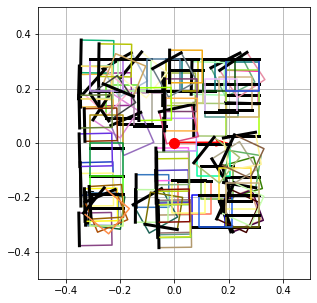

Memory:  0.0007598080000000001 0.847249408
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Policy Iteration 1/30
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Number of value updates:  1
.....................................................
Computing Advantage Fcn
.....................................................
v_min: -1.21, v_mean: -0.64, v_max: -0.01
a_min: -121.69, a_mean: -64.65, a_max: -0.68
p_min: 122.01, p_mean: 179.04, p_max: 243.01
Rank of V-model:  tensor([1, 4, 2, 1, 1, 1, 1])
Rank of A-model:  tensor([1, 4, 2, 3, 3, 5, 6, 3, 2, 1])
Rank of P-model:  tensor([1, 6, 4, 5, 5, 7, 8, 5, 4, 1])
--------------------------------------------
Time taken:1.7080044746398926
--------------------------------------------
Memory:  0.000554496 0.006291456000000001
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Policy Iteration 2/30
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Number of value updates:  1
.....................................................
Computing Advantage Fcn
...................

.....................................................
Computing Advantage Fcn
.....................................................
v_min: -5.93, v_mean: -3.13, v_max: -0.02
a_min: -123.14, a_mean: -64.64, a_max: -0.10
p_min: 124.04, p_mean: 182.54, p_max: 247.08
Rank of V-model:  tensor([1, 9, 4, 2, 2, 2, 1])
Rank of A-model:  tensor([ 1,  6,  4,  6,  7,  8, 10,  5,  3,  1])
Rank of P-model:  tensor([ 1,  8,  6,  8,  9, 10, 12,  7,  5,  1])
--------------------------------------------
Time taken:4.5010552406311035
--------------------------------------------
Memory:  0.0009507840000000001 0.008388608
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Policy Iteration 6/30
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Number of value updates:  1
.....................................................
Computing Advantage Fcn
.....................................................
v_min: -7.08, v_mean: -3.74, v_max: -0.03
a_min: -123.21, a_mean: -64.63, a_max: -0.16
p_min: 124.04, p_mean: 182.62, p_max

.....................................................
Computing Advantage Fcn
.....................................................
v_min: -8.22, v_mean: -4.34, v_max: -0.03
a_min: -124.61, a_mean: -64.62, a_max: 1.60
p_min: 127.22, p_mean: 187.21, p_max: 253.43
Rank of V-model:  tensor([1, 6, 2, 3, 2, 1, 1])
Rank of A-model:  tensor([ 1,  6,  4,  6, 10,  9, 12,  7,  4,  1])
Rank of P-model:  tensor([ 1,  8,  6,  8, 12, 11, 14,  9,  6,  1])
--------------------------------------------
Time taken:5.418534278869629
--------------------------------------------
Memory:  0.001102336 0.006291456000000001
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Policy Iteration 8/30
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Number of value updates:  1


.....................................................
Computing Advantage Fcn
.....................................................
v_min: -9.34, v_mean: -4.93, v_max: -0.03
a_min: -126.43, a_mean: -64.61, a_max: 2.04
p_min: 129.47, p_mean: 191.29, p_max: 257.94
Rank of V-model:  tensor([1, 6, 2, 3, 2, 1, 1])
Rank of A-model:  tensor([ 1,  6,  4,  6, 12, 11, 14,  9,  4,  1])
Rank of P-model:  tensor([ 1,  8,  6,  8, 14, 13, 16, 11,  6,  1])
--------------------------------------------
Time taken:5.3933796882629395
--------------------------------------------
Memory:  0.001271296 0.006291456000000001
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Policy Iteration 9/30
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Number of value updates:  1
.....................................................
Computing Advantage Fcn
.....................................................
v_min: -10.45, v_mean: -5.52, v_max: -0.04
a_min: -128.83, a_mean: -64.61, a_max: 1.86
p_min: 131.70, p_mean: 195.92, p_max: 

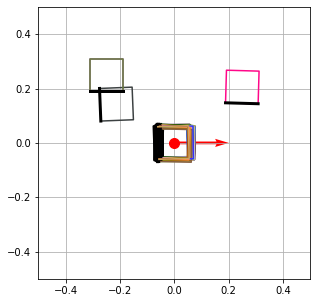

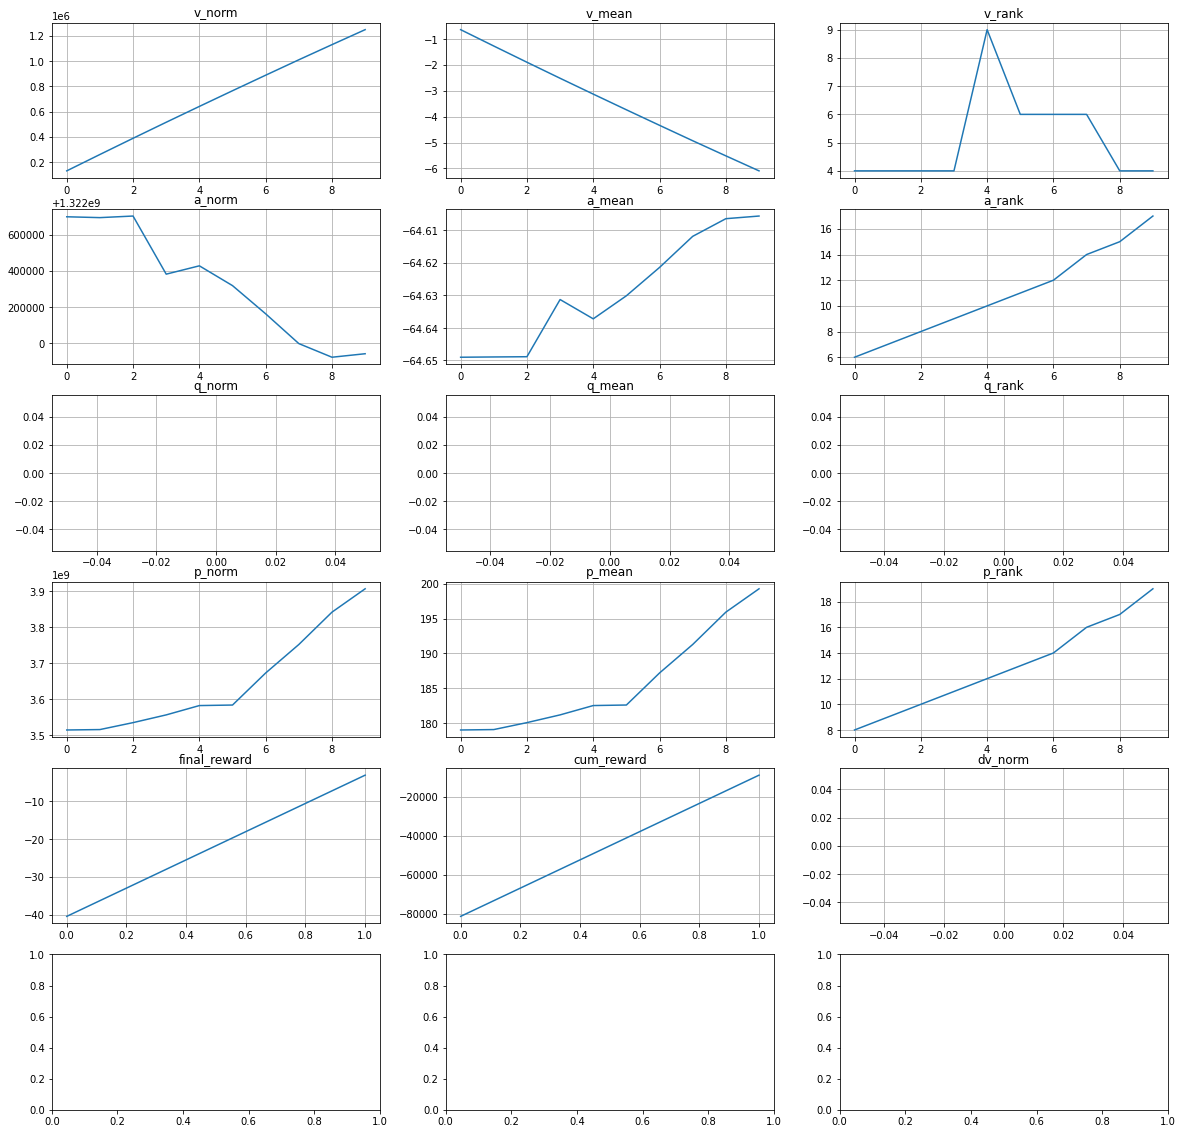

Memory:  0.001686016 0.048234496
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Policy Iteration 11/30
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Number of value updates:  1
.....................................................
Computing Advantage Fcn
.....................................................
v_min: -12.65, v_mean: -6.67, v_max: -0.03
a_min: -132.36, a_mean: -64.61, a_max: 1.96
p_min: 135.32, p_mean: 203.08, p_max: 269.64
Rank of V-model:  tensor([1, 4, 2, 3, 3, 1, 1])
Rank of A-model:  tensor([ 1,  6,  4,  7, 18, 15, 18, 12,  5,  1])
Rank of P-model:  tensor([ 1,  8,  6,  9, 20, 17, 20, 14,  7,  1])
--------------------------------------------
Time taken:1.9951045513153076
--------------------------------------------
Memory:  0.0018493440000000002 0.006291456000000001
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Policy Iteration 12/30
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Number of value updates:  1
.....................................................
Computing Advantage F

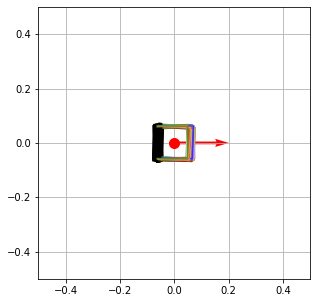

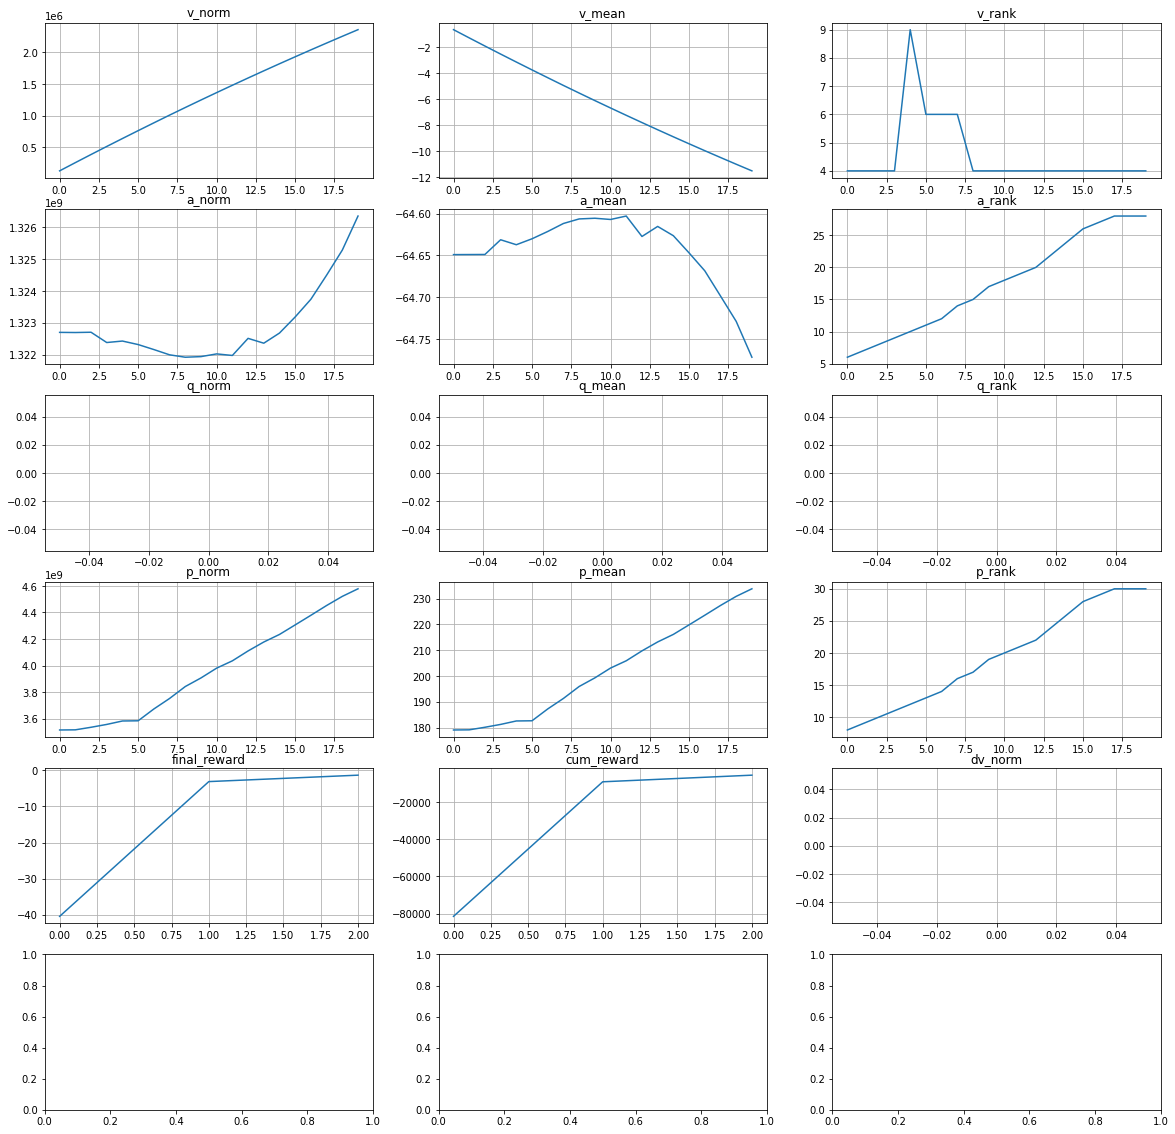

Memory:  0.003206656 0.052428800000000005
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Policy Iteration 21/30
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Number of value updates:  1
.....................................................
Computing Advantage Fcn
.....................................................
v_min: -22.98, v_mean: -12.01, v_max: 0.06
a_min: -150.37, a_mean: -64.82, a_max: 2.74
p_min: 154.12, p_mean: 239.67, p_max: 307.23
Rank of V-model:  tensor([1, 4, 2, 3, 3, 1, 1])
Rank of A-model:  tensor([ 1,  8,  5, 10, 29, 23, 26, 21,  7,  1])
Rank of P-model:  tensor([ 1, 10,  7, 12, 31, 25, 28, 23,  9,  1])
--------------------------------------------
Time taken:3.54184627532959
--------------------------------------------
Memory:  0.003595776 0.008388608
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Policy Iteration 22/30
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Number of value updates:  1
.....................................................
Computing Advantage Fcn
.........

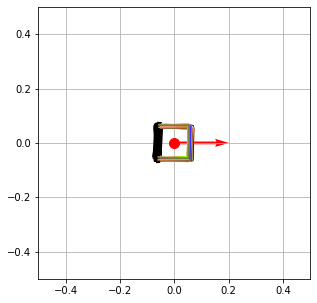

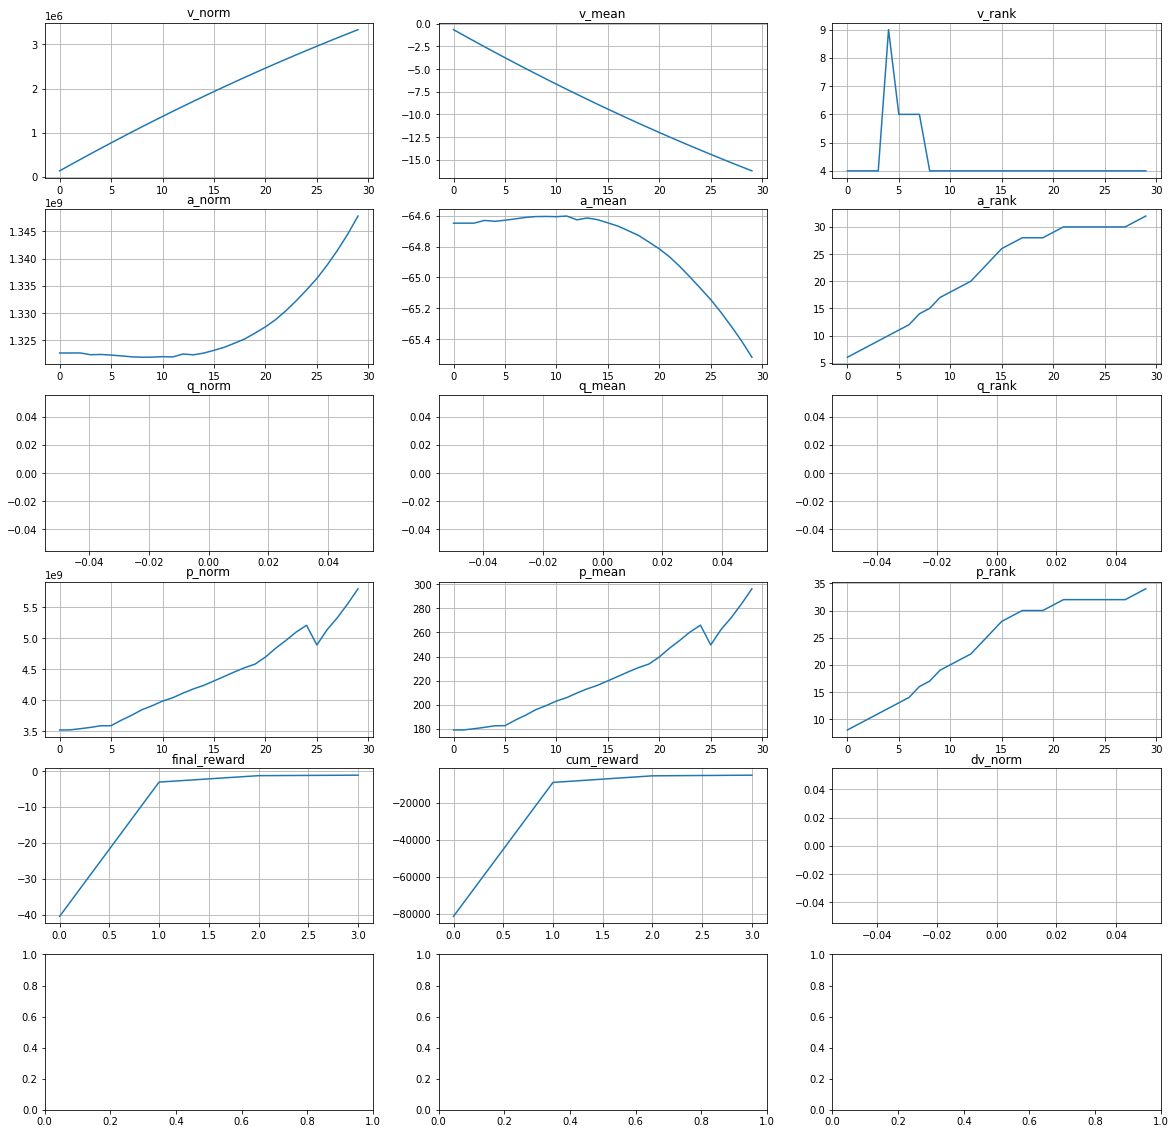

In [13]:
resume= False
rtt.train(n_iter_max=30,n_iter_v=1,
        callback=callback, callback_freq=10,
        verbose=False, file_name='ttpi_pushing')


"